In [1]:
# https://youtu.be/tepxdcepTbY
"""
@author: Sreenivas Bhattiprolu
Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3
dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""

'\n@author: Sreenivas Bhattiprolu\nCode tested on Tensorflow: 2.2.0\n    Keras: 2.4.3\ndataset: https://finance.yahoo.com/quote/GE/history/\nAlso try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC\n'

In [2]:
!pip install statsmodels==0.12.0

In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime
import json

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pd.set_option("display.max_rows", 12, "display.max_columns", None)

# Import data and create a single dataframe

Επειδή τα δεδομένα μας είναι διάσπαρτα ανά 20 λεπτά περίπου σε κάθε ώρα, κάνουμε ένα downsampling ανά ώρα, για να έχουμε μια πιο γενική εικόνα των μετρήσεων ανά ώρα, και για να ταυτίζονται οι χρονικές στιγμές των δεδομένων τόσο στις καιρικές μετρήσεις, όσο και στις μετρήσεις των pollutants.

In [6]:
## Import Weather data and do some changes in the reading function, because the format isn't appropriate for direct reading from pandas' functions
## Also do some downsampling for measures per Hour.

import json

def readfile(file):
  data = {'datetime': [], 'value': []}
  with open('drive/MyDrive/Xenias-Data/{}'.format(file), 'r') as f:
    for line in f:
          dictionary = json.loads(line)
          for key in dictionary:
              if key == '':
                  pass
              elif dictionary[key] == '':
                  data['datetime'].append(key)
                  data['value'].append(None)
              else:
                  data['datetime'].append(key)
                  data['value'].append(float(dictionary[key]))


  df = pd.DataFrame(data=data)
  df['datetime_pd'] = pd.to_datetime(df['datetime'], infer_datetime_format=True)
  df.set_index(['datetime_pd'], inplace=True)
  df = df.rename(columns={'value': file.split('.')[0]})
  df = df.groupby(pd.Grouper(freq='H')).mean()
  df = df.sort_index()
  return df


files = [ 'hum.txt', 'dewptm.txt', 'pressurem.txt', 'wdird.txt', 'wspdm.txt']

df_w = readfile('tempm.txt')
for x in files:
  y = readfile(x)
  df_w = df_w.merge(y, left_index=True, right_index=True)
print(df_w)

                         tempm        hum     dewptm    pressurem       wdird  \
datetime_pd                                                                     
2014-08-01 00:00:00  18.000000  64.000000  11.666667  1012.000000  213.333333   
2014-08-01 01:00:00  18.333333  70.000000  13.333333  1012.000000  210.000000   
2014-08-01 02:00:00  18.666667  75.333333  14.333333  1012.000000  213.333333   
2014-08-01 03:00:00  18.000000  79.666667  15.000000  1012.000000  226.666667   
2014-08-01 04:00:00  17.666667  80.333333  14.666667  1012.000000  223.333333   
...                        ...        ...        ...          ...         ...   
2014-09-30 19:00:00  14.000000  74.666667  10.000000  1025.333333  106.666667   
2014-09-30 20:00:00  14.000000  75.000000  10.000000  1025.333333  106.666667   
2014-09-30 21:00:00  14.000000  75.333333  10.000000  1025.666667  113.333333   
2014-09-30 22:00:00  14.000000  75.333333  10.000000  1026.000000  113.333333   
2014-09-30 23:00:00  14.0000

In [7]:
## Import pollution data directly from pandas' fucntion and do the downsampling too.
df = pd.read_csv('drive/MyDrive/Xenias-Data/pollutionData210199.csv')
df['datetime_pd'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
df.rename(columns={'timestamp': 'datetime'}, inplace=True)
df.set_index('datetime_pd', inplace=True)
df_p = df.groupby(pd.Grouper(freq='H')).mean().drop(columns=['longitude', 'latitude'])
print(df_p)

                          ozone  particullate_matter  carbon_monoxide  \
datetime_pd                                                             
2014-08-01 00:00:00   82.181818            82.363636        23.000000   
2014-08-01 01:00:00   78.166667            78.666667        28.833333   
2014-08-01 02:00:00   67.166667            89.333333        44.333333   
2014-08-01 03:00:00   73.000000            95.833333        59.333333   
2014-08-01 04:00:00   86.250000            85.500000        66.250000   
...                         ...                  ...              ...   
2014-09-30 20:00:00  187.666667           206.583333       203.916667   
2014-09-30 21:00:00  191.916667           209.000000       207.833333   
2014-09-30 22:00:00  189.500000           200.750000       198.333333   
2014-09-30 23:00:00  195.000000           197.583333       194.083333   
2014-10-01 00:00:00  200.000000           190.000000       193.000000   

                     sulfure_dioxide  nitrogen_dio

In [8]:
## Merge the above dataframes to one, with inner join between the indexes.
df = df_w.merge(df_p, left_index=True, right_index=True)

## Check for NaN values
print(df.isna().sum())

## Check the statistic indexes for the records
print(df.describe())


tempm                  0
hum                    0
dewptm                 0
pressurem              0
wdird                  0
wspdm                  0
ozone                  0
particullate_matter    0
carbon_monoxide        0
sulfure_dioxide        0
nitrogen_dioxide       0
dtype: int64
             tempm          hum       dewptm    pressurem        wdird  \
count  1464.000000  1464.000000  1464.000000  1464.000000  1464.000000   
mean     15.587318    70.082081    10.351890  1013.842099   184.881603   
std       3.577939    14.046408     2.795900     7.872343    79.927421   
min       2.666667    23.333333     0.000000   992.333333     0.000000   
25%      13.000000    61.333333     8.666667  1008.666667   116.666667   
50%      15.333333    73.000000    10.666667  1013.000000   200.000000   
75%      18.000000    81.000000    12.000000  1019.666667   246.666667   
max      27.000000    92.333333    19.000000  1030.000000   360.000000   

             wspdm        ozone  particullate

# Data Visualization

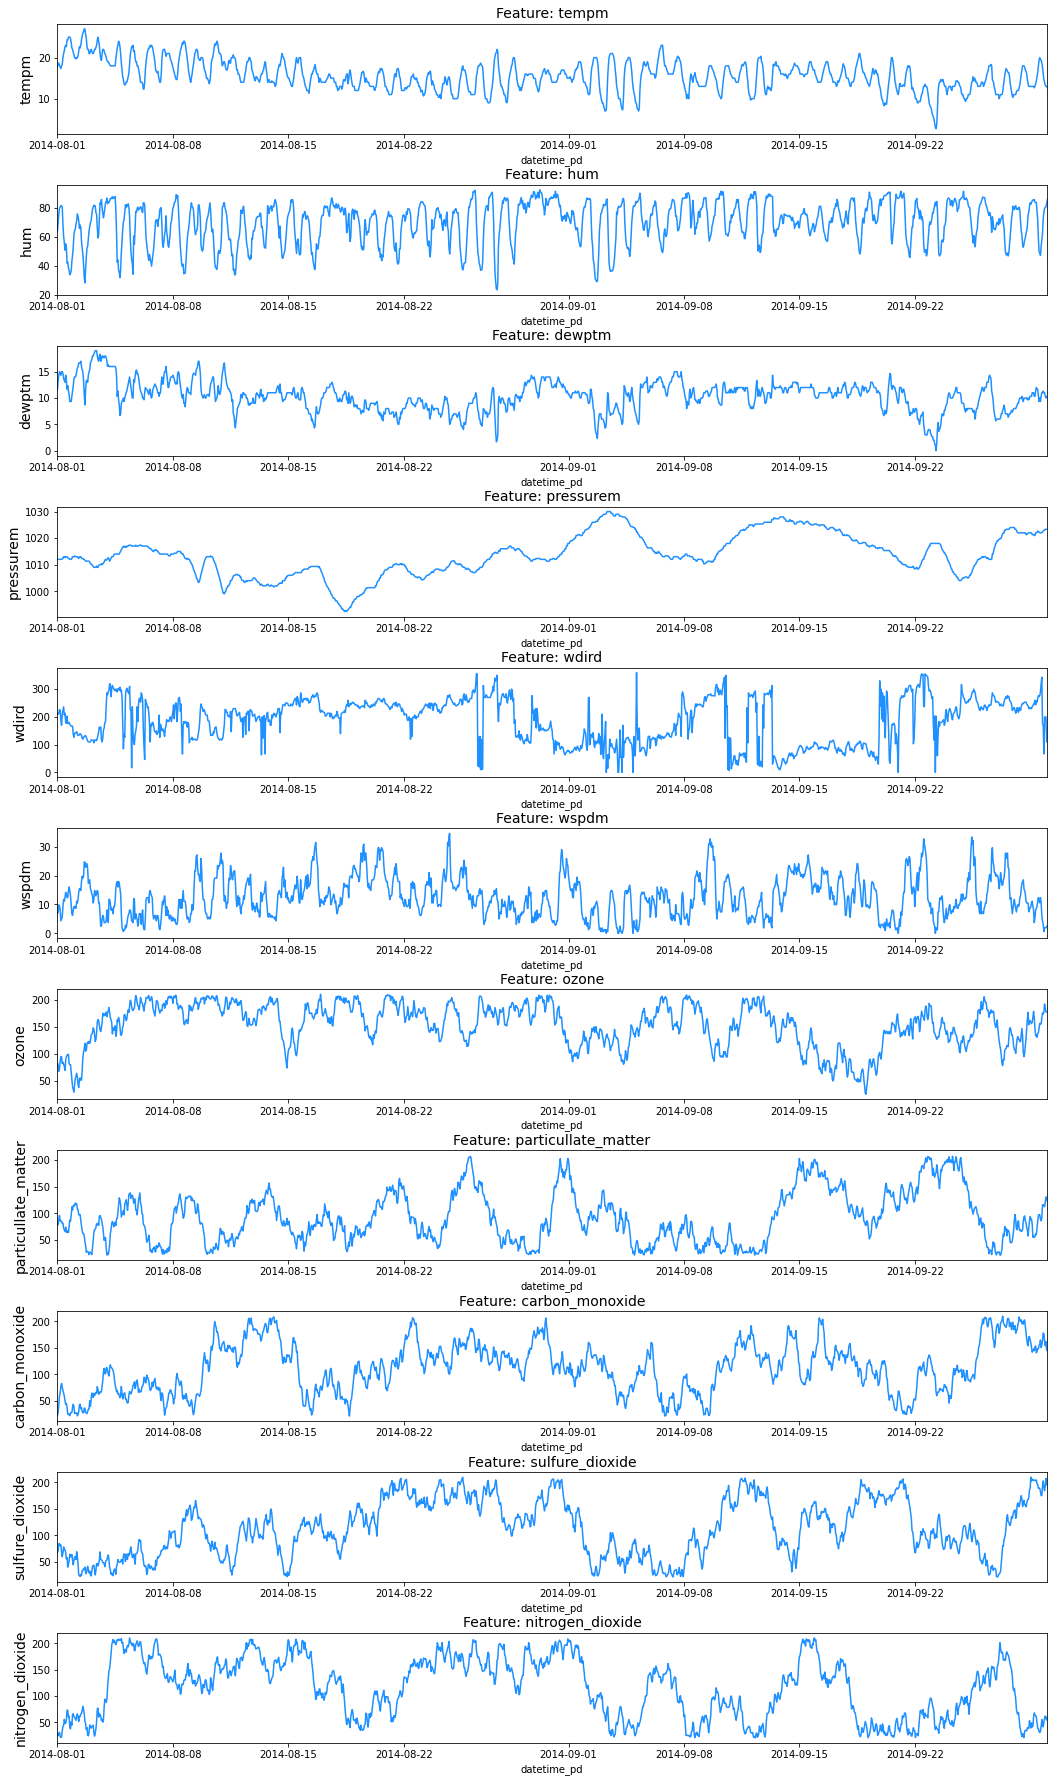

In [9]:
from datetime import datetime, date 
f, ax = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(15, 25))
f.tight_layout(pad=3.0)
for i, column in enumerate(df.columns):
    sns.lineplot(x=df.index, y=df[column], ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2014, 8, 1), date(2014, 9, 30)])            

# Data Preprocessing and Diagnostic Analytics


Παρατηρούμε λοιπόν ότι όταν η μέτρηση **wind speed** είναι 0, τότε όπως είναι λογικό και σχεδόν αναγκαίο, η μέτρηση **wind direction** είναι εξίσου 0. Επομένως οι μετρήσεις μας είναι σωστές και δεν χρειάζεται κάποια αλλαγή (π.χ. interpolation)

## Handle Missing or Inaccurate Values




Αρχικά έχουμε εξακριβώσει μέσα από την εντολή **df.isna().sum()** ότι δεν υπάρχει καμία στήλη με μέτρηση που να είναι NaN.

Παρατηρώντας τις γραφικές παραστάσεις των δεδομένων μας όμως και σε συνδυασμό με τα αποτελέσματα της εντολής 

```
df.describe()
```
παρατηρούμε ότι στις μεταβλητές **''wind direction''** και **''wind speed'**' υπάρχουν μετρήσεις που έχουν μηδενική τιμή. Κάτι τέτοιο θα μπορούσε να συνέβαινε ως σφάλμα μέτρησης το οποίο απλά θα έβαζε μια τιμή 0 αντί για μια NaN τιμή. Πρέπει να ελέγξουμε εάν αυτές οι μηδενικές μετρήσεις ευσταθούν.

In [10]:
print(df.loc[df['wspdm'] ==0])
print()
print(len(df.loc[df['wspdm'] ==0]),' records')
print('--------------------------------------------------------')
print(df.loc[df['wdird'] ==0])
print()
print(len(df.loc[df['wdird'] ==0]), ' records')
print('--------------------------------------------------------')

                         tempm        hum    dewptm    pressurem  wdird  \
datetime_pd                                                               
2014-09-03 07:00:00   7.333333  85.333333  5.333333  1029.333333    0.0   
2014-09-04 00:00:00  11.000000  79.666667  8.000000  1029.000000    0.0   
2014-09-04 01:00:00  10.000000  81.000000  7.333333  1029.000000    0.0   
2014-09-04 06:00:00   7.333333  83.333333  5.000000  1028.000000    0.0   
2014-09-04 22:00:00  12.666667  80.333333  9.666667  1024.000000    0.0   
2014-09-21 00:00:00  11.000000  86.333333  9.000000  1011.666667    0.0   
2014-09-23 06:00:00   3.000000  83.666667  1.000000  1018.000000    0.0   

                     wspdm       ozone  particullate_matter  carbon_monoxide  \
datetime_pd                                                                    
2014-09-03 07:00:00    0.0  133.166667           104.833333       106.166667   
2014-09-04 00:00:00    0.0  125.750000            67.166667        47.000000   
2014

## Stationarity

Αρχικά μελετάμε το stationarity των χρονοσειρών μας. Αυτό είναι σημαντικό γιατί κάποια στατιστικά μοντέλα όπως το ARIMA απαιτεί η χρονοσειρά να είναι stationary.  

Stationarity describes that the time-series has


*   constant mean and mean is not time-dependent
*   constant variance and variance is not time-dependent
*   constant covariance and covariance is not time-dependent



###  Visual check

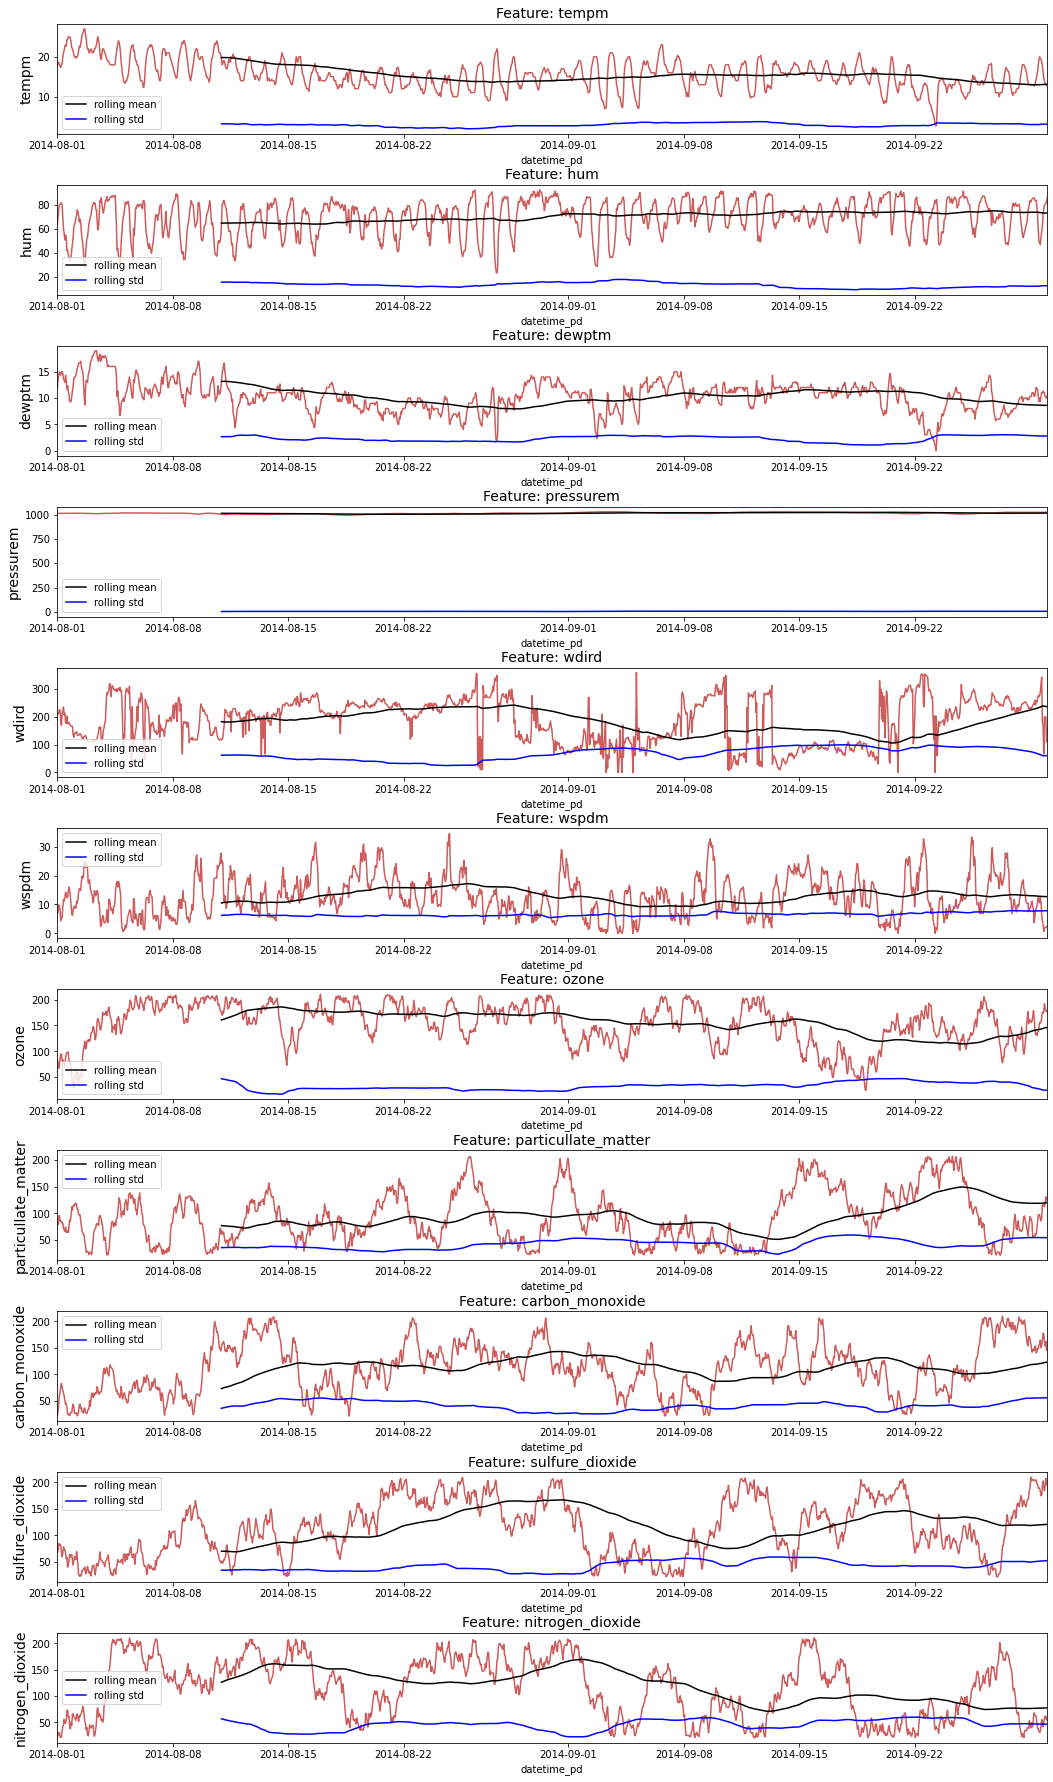

In [11]:
from datetime import datetime, date 
f, ax = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(15, 25))
f.tight_layout(pad=3.0)
for i, column in enumerate(df.columns):
    sns.lineplot(x=df.index, y=df[column], ax=ax[i], color='indianred')
    sns.lineplot(x=df.index, y=df[column].rolling(24 * 10).mean(), ax=ax[i], color='black', label='rolling mean')
    sns.lineplot(x=df.index, y=df[column].rolling(24 * 10).std(), ax=ax[i], color='blue', label='rolling std')  
    #sns.lineplot(x=df.index, y=df[column].rolling(168).var(), ax=ax[i], color='orange', label='rolling var')  
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2014, 8, 1), date(2014, 9, 30)])  

Let's evaluate the histograms. Since we are looking at the mean and variance, we are expecting that the data conforms to a Gaussian distribution (bell shaped distribution) in case of stationarity

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

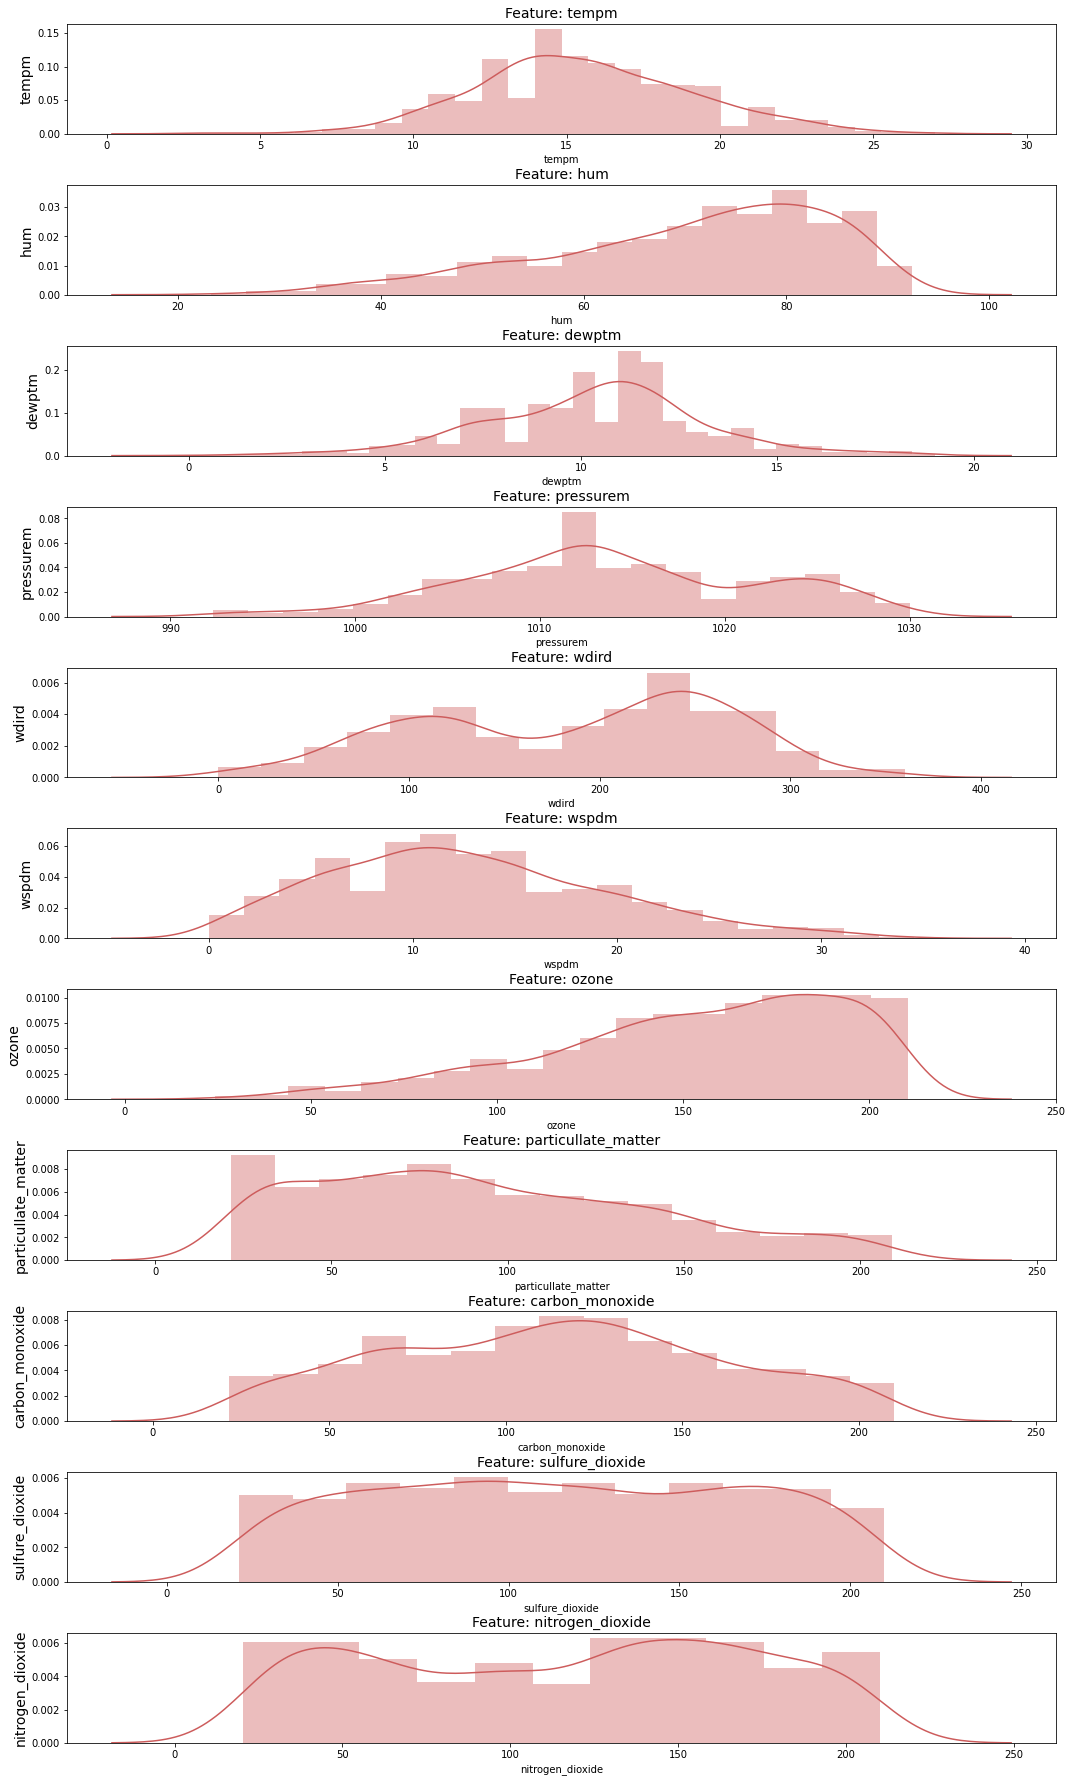

In [12]:
from datetime import datetime, date 
f, ax = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(15, 25))
f.tight_layout(pad=3.0)
for i, column in enumerate(df.columns):
    sns.distplot( df[column], ax=ax[i], color='indianred')
    #sns.lineplot(x=df.index, y=df[column].rolling(168).var(), ax=ax[i], color='orange', label='rolling var')  
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)


### ADF Test

Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

* Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

* Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

* p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

* ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

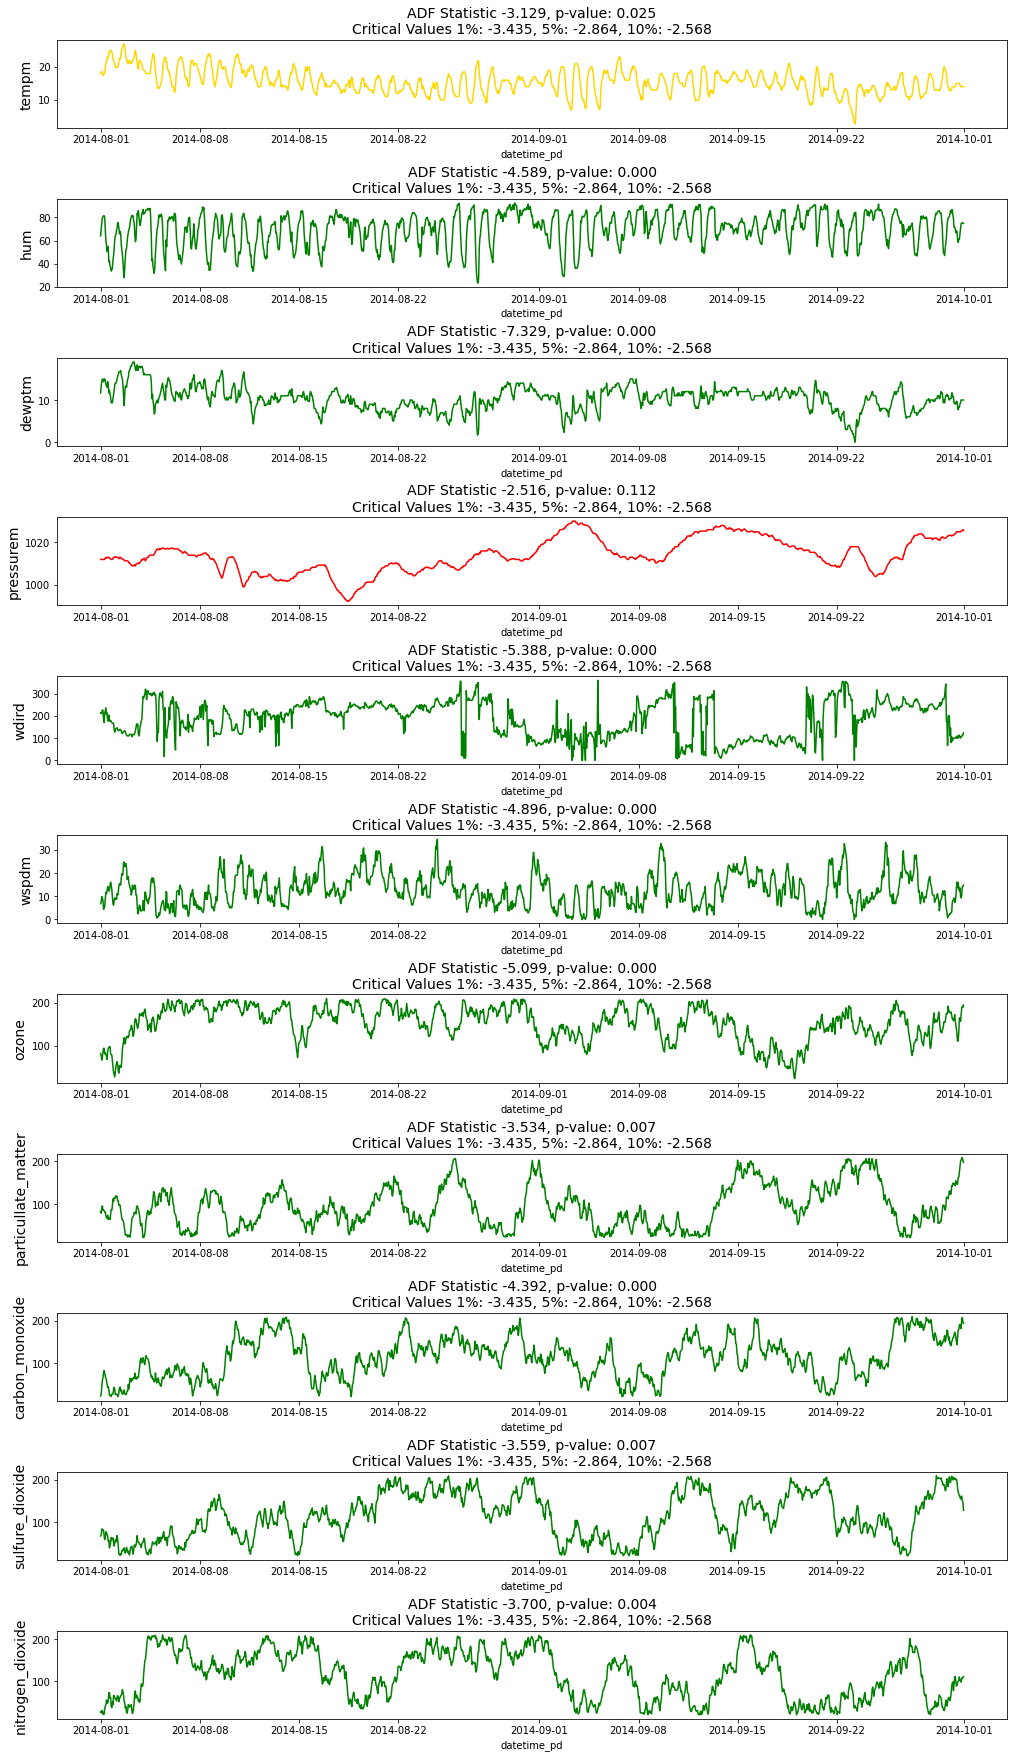

In [13]:
f, ax = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(15, 25))
f.tight_layout(pad=5.0)
from statsmodels.tsa.stattools import adfuller
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'green' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'purple'
    else:
        linecolor = 'red'
    sns.lineplot(x=df.index, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

for i, column in enumerate(df.columns):
  visualize_adfuller_results(df[column].values, column, ax[i])

If the data is not stationary but we want to use a model that requires with characteristic, the data has to be transformed. However, if the data is not stationary to begin with, we should rethink the choice of model.

The two most common methods to achieve stationarity are:

* Transformation: e.g. log or square root to stabilize non-constant variance
* Differencing: subtracts the current value from the previous


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

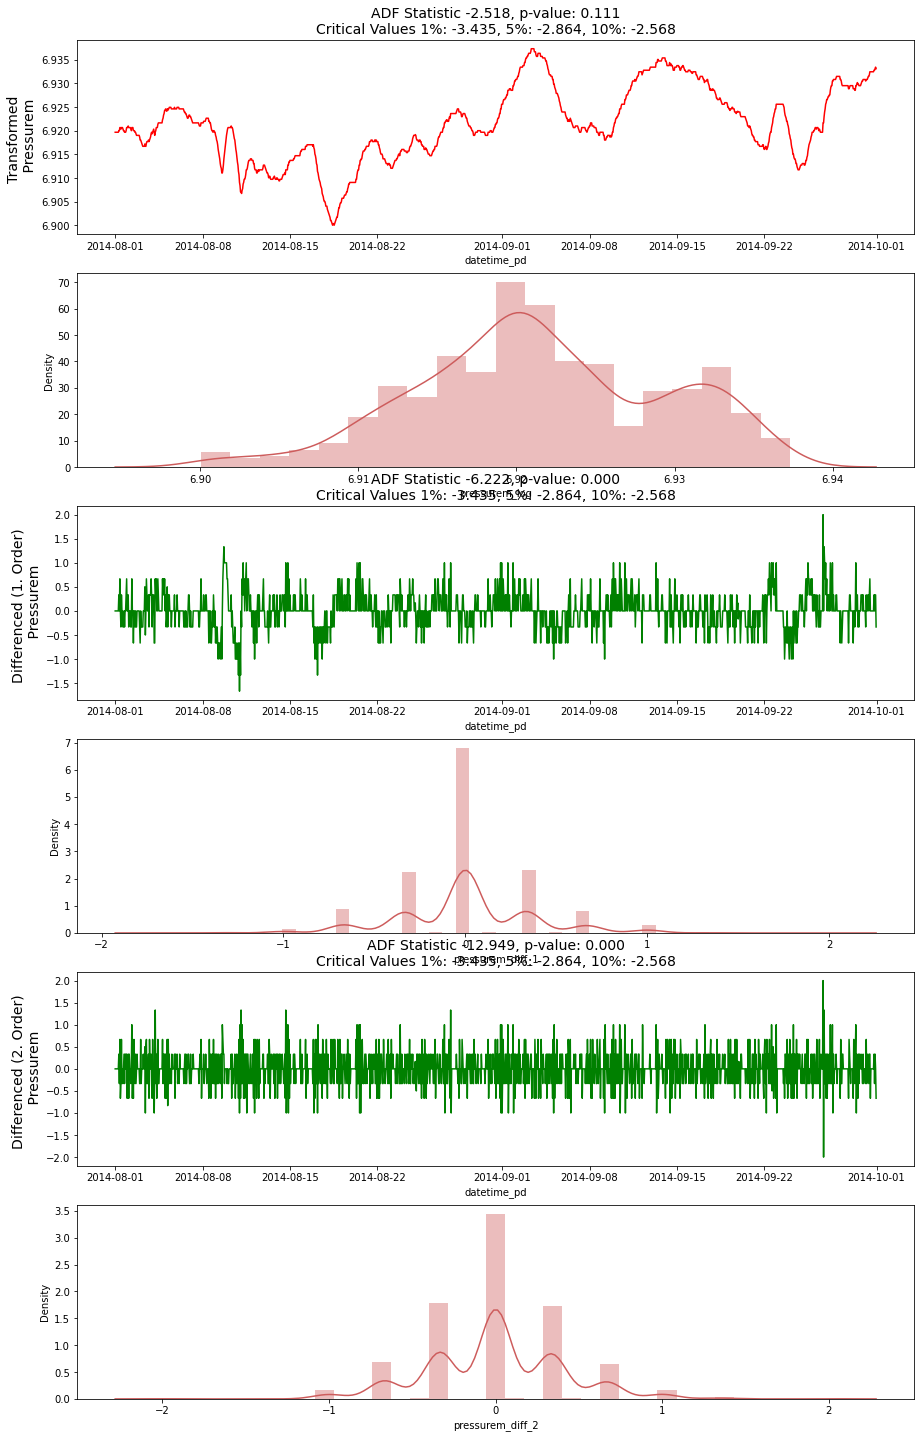

In [14]:
# Transformation
df['pressurem_log'] = np.log(abs(df['pressurem']))

# Differencing
ts_diff = np.diff(df['pressurem'])
df['pressurem_diff_1'] = np.append([0], ts_diff)

# Second Order Differencing
ts_diff = np.diff(df.pressurem_diff_1)
df['pressurem_diff_2'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 25))
visualize_adfuller_results(df.pressurem_log, 'Transformed \n Pressurem', ax[0])
sns.distplot(df.pressurem_log, ax=ax[1], color='indianred')
visualize_adfuller_results(df.pressurem_diff_1, 'Differenced (1. Order) \n Pressurem', ax[2])
sns.distplot( df.pressurem_diff_1, ax=ax[3], color='indianred')
visualize_adfuller_results(df.pressurem_diff_2, 'Differenced (2. Order) \n Pressurem', ax[4])
sns.distplot( df.pressurem_diff_2, ax=ax[5], color='indianred')

## Feature Engineering

### Time Features

In [15]:
df['year'] = pd.DatetimeIndex(df.index).year
df['month'] = pd.DatetimeIndex(df.index).month
df['day'] = pd.DatetimeIndex(df.index).day
df['day_of_year'] = pd.DatetimeIndex(df.index).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df.index).weekofyear
df['quarter'] = pd.DatetimeIndex(df.index).quarter
df[['year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter']].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


year  month  day  day_of_year  week_of_year  quarter
datetime_pd                                                              
2014-08-01 00:00:00  2014      8    1          213            31        3
2014-08-01 01:00:00  2014      8    1          213            31        3
2014-08-01 02:00:00  2014      8    1          213            31        3
2014-08-01 03:00:00  2014      8    1          213            31        3
2014-08-01 04:00:00  2014      8    1          213            31        3

### Decomposition

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
  
decompose_cols =  ['tempm', 'hum', 'dewptm', 'pressurem','wdird', 'wspdm','ozone','particullate_matter',        
                   'carbon_monoxide','sulfure_dioxide','nitrogen_dioxide']

for col in decompose_cols:
    decomp = seasonal_decompose(df[col], freq=168, model='additive', extrapolate_trend='freq')
    df[f"{col}_trend"] = decomp.trend
    df[f"{col}_seasonal"] = decomp.seasonal


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


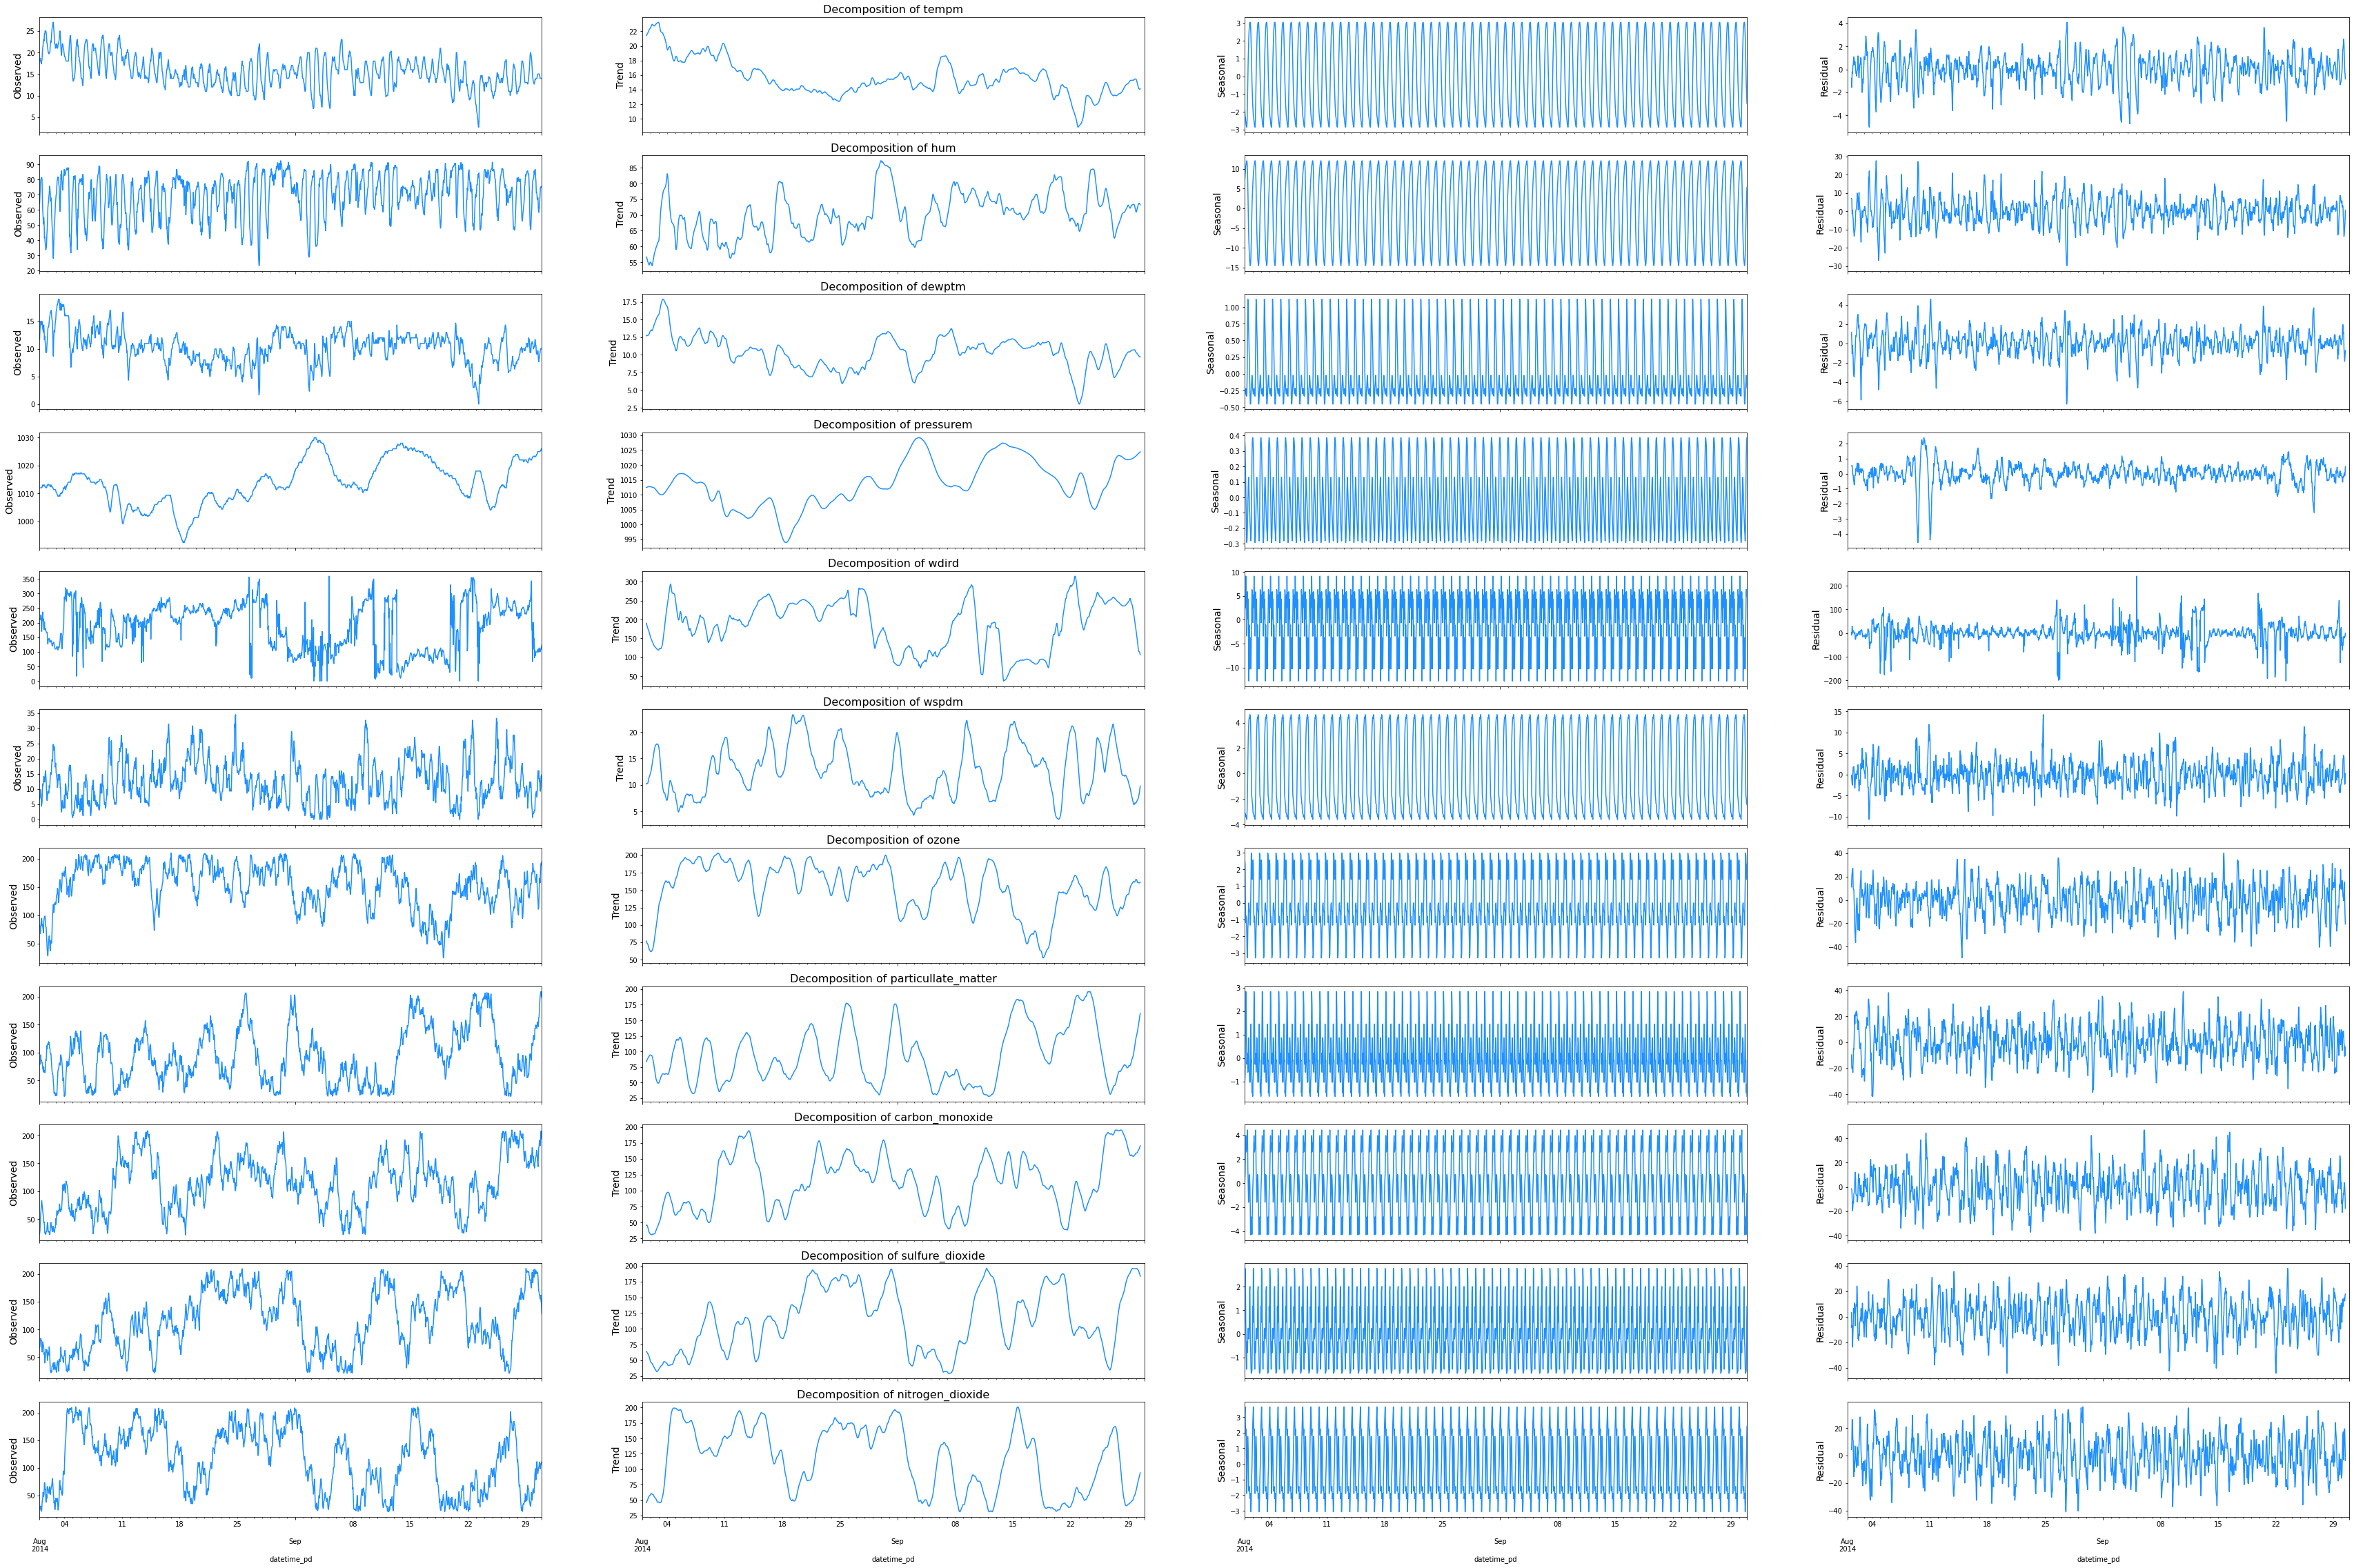

In [17]:
fig, ax = plt.subplots(ncols=4, nrows=len(decompose_cols), sharex=True,figsize=(60, 40))

for i, col in enumerate(decompose_cols):
  res = seasonal_decompose(df[col], model='additive')
  ax[i,1].set_title('Decomposition of {}'.format(col), fontsize=16)
  res.observed.plot(ax=ax[i,0], legend=False, color='dodgerblue')
  ax[i,0].set_ylabel('Observed', fontsize=14)

  res.trend.plot(ax=ax[i,1], legend=False, color='dodgerblue')
  ax[i,1].set_ylabel('Trend', fontsize=14)

  res.seasonal.plot(ax=ax[i,2], legend=False, color='dodgerblue')
  ax[i,2].set_ylabel('Seasonal', fontsize=14)

  res.resid.plot(ax=ax[i,3], legend=False, color='dodgerblue')
  ax[i,3].set_ylabel('Residual', fontsize=14)

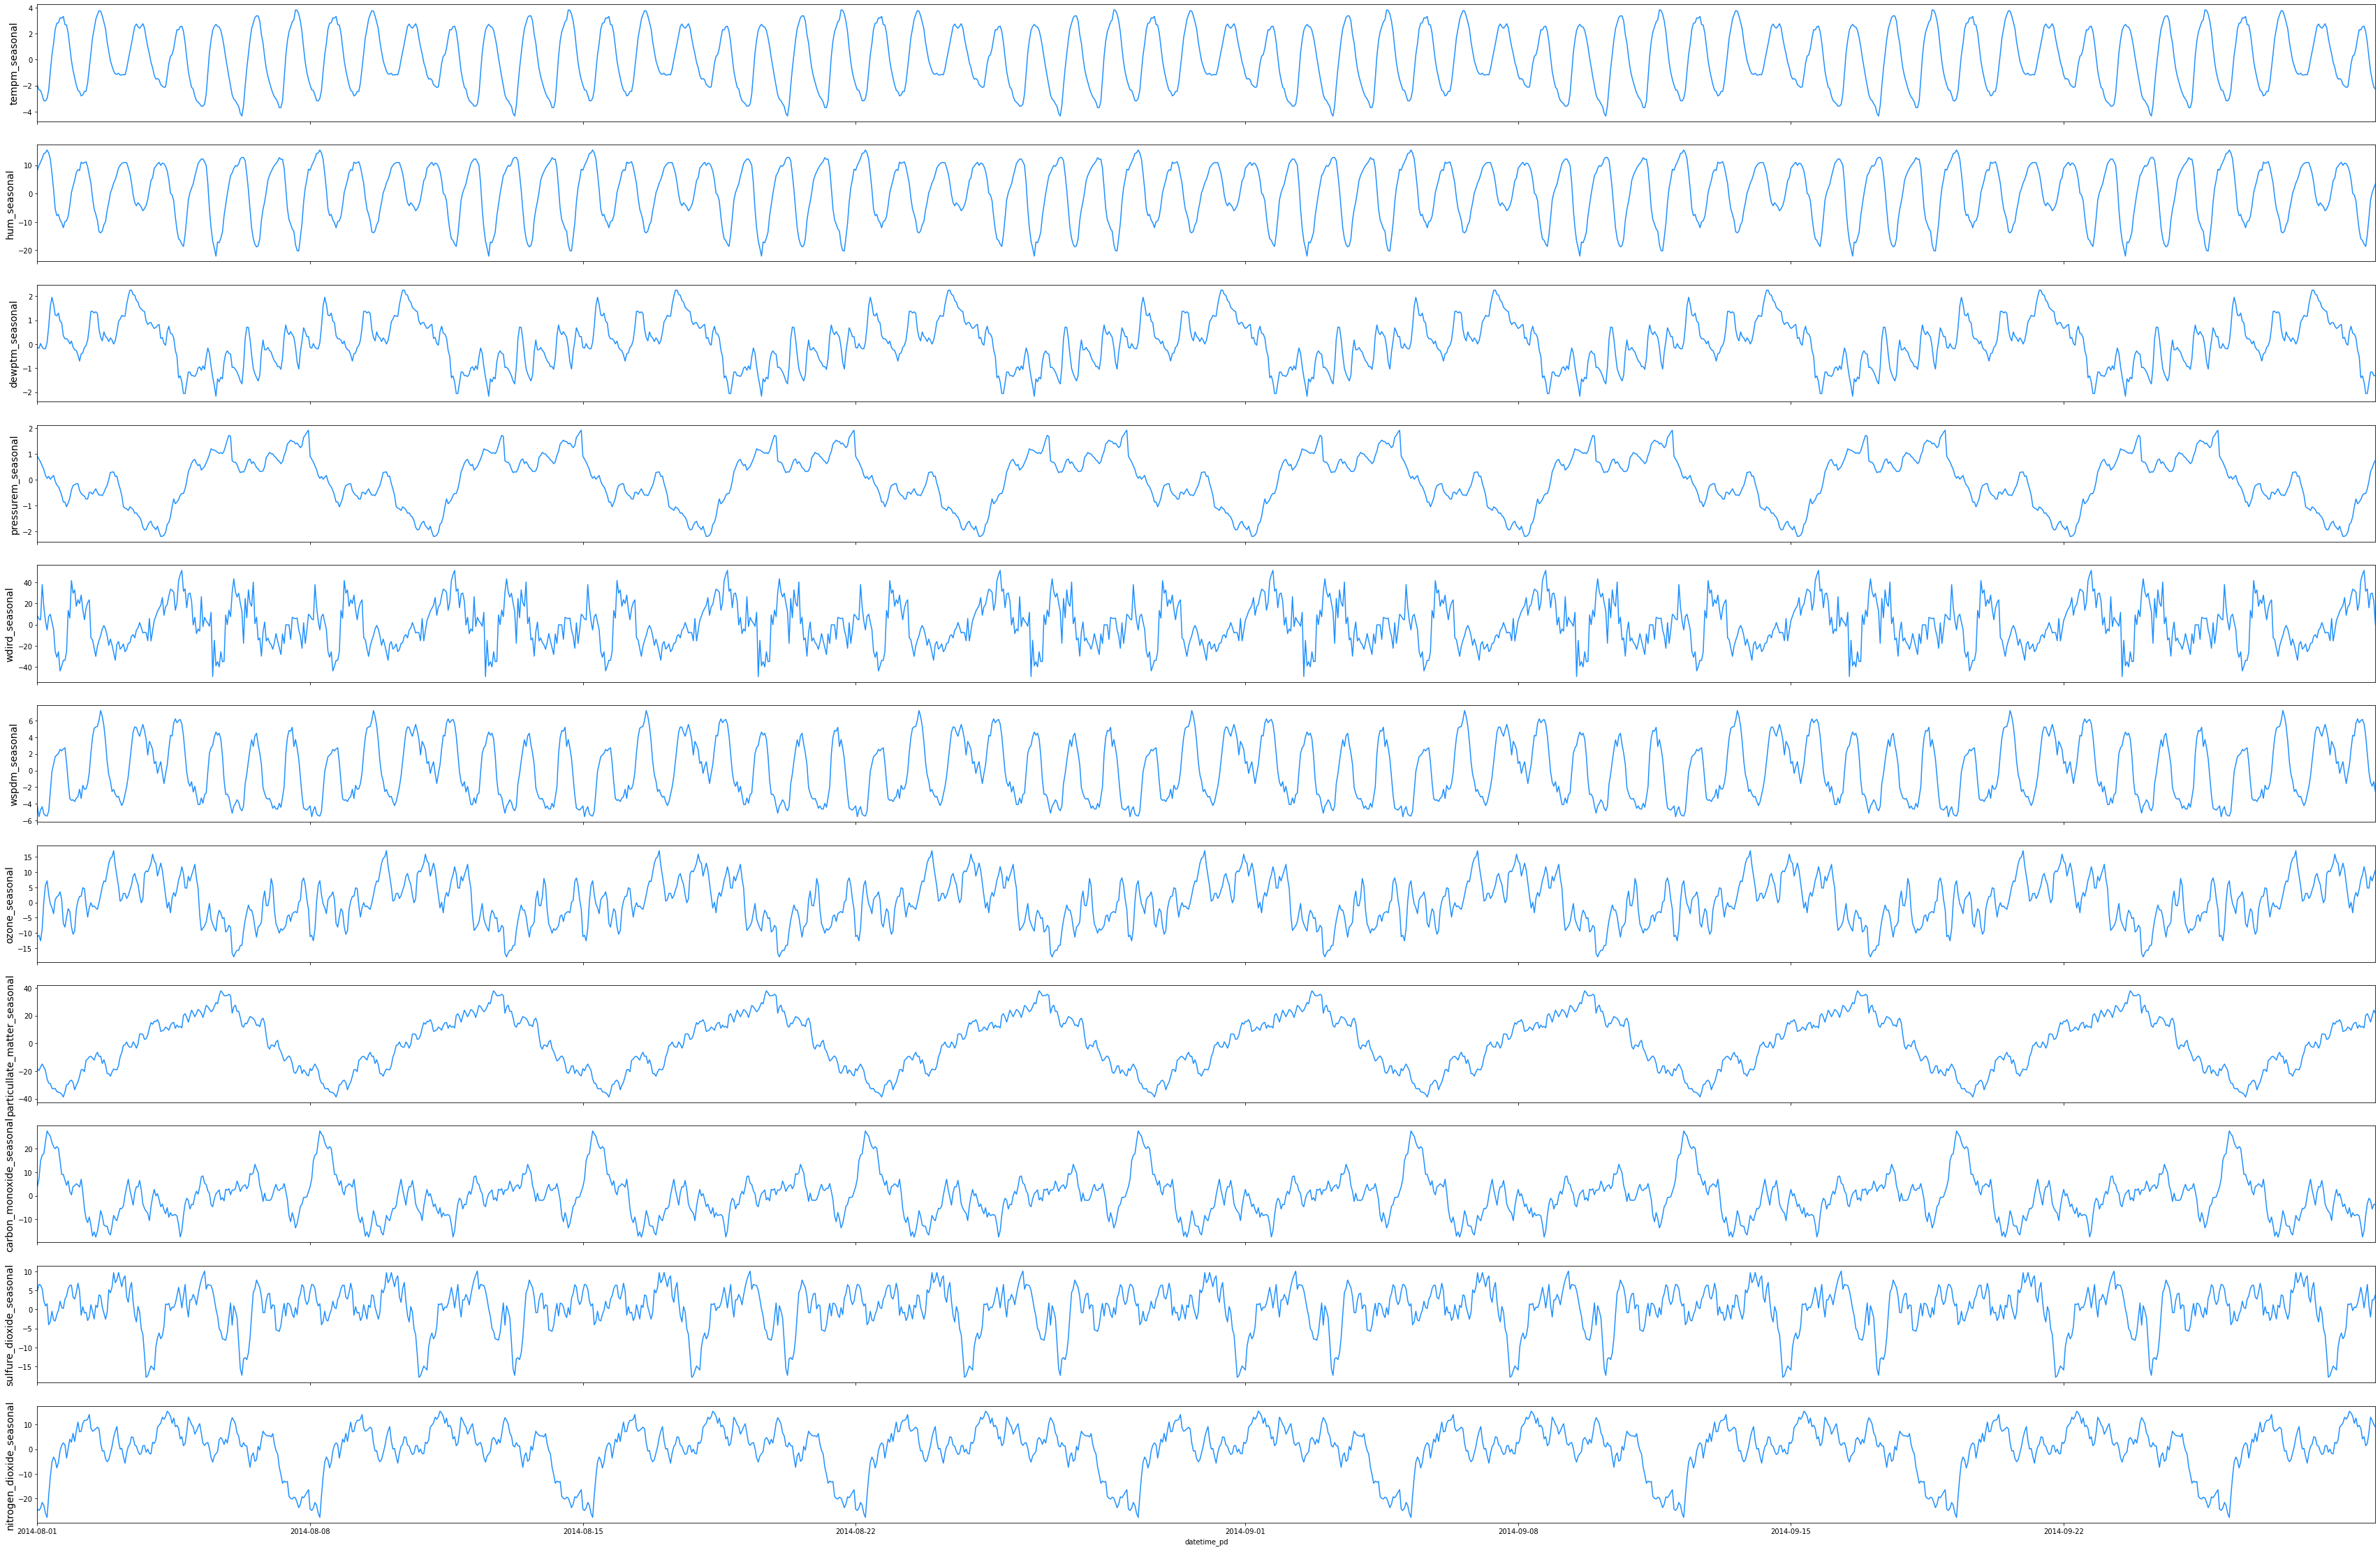

In [18]:

fig, ax = plt.subplots(ncols=1, nrows=len(decompose_cols), sharex=True,figsize=(60, 40))
f.suptitle('Seasonal Components of Features', fontsize=16)
for i, col in enumerate(decompose_cols):
  sns.lineplot(x=df.index, y=df['{}_seasonal'.format(col)], ax=ax[i], color='dodgerblue')
  ax[i].set_ylabel(ylabel='{}_seasonal'.format(col), fontsize=14)
  ax[i].set_xlim([date(2014, 8, 1), date(2014, 9, 30)])  

### Covariances

Κατα πόσο μεταβάλλονται ανάλογα (Θετική cov) ή αντιστρόφως ανάλογα (αρνητική cov) ή όταν τα δυο σύνολα είναι ασυσχέτιστα μεταξύ τους (μηδενική cov).

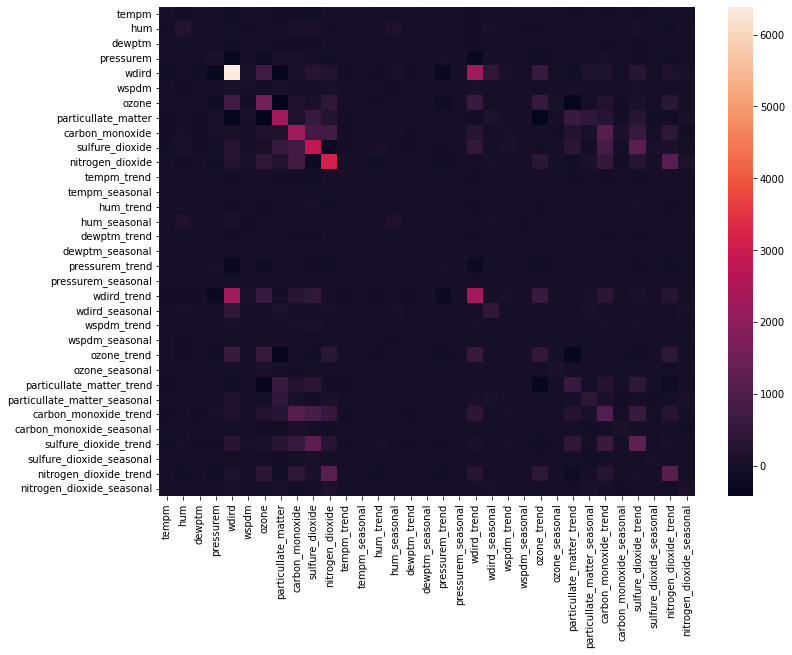

In [19]:

import seaborn as sn

f, ax = plt.subplots(figsize=(12, 9))
df_copy = df.copy()
df_copy = df_copy.drop(columns=['year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter','pressurem_log','pressurem_diff_1','pressurem_diff_2'])

covMatrix = pd.DataFrame.cov(df_copy)
sn.heatmap(covMatrix, fmt='g')
plt.show()

### Correlations

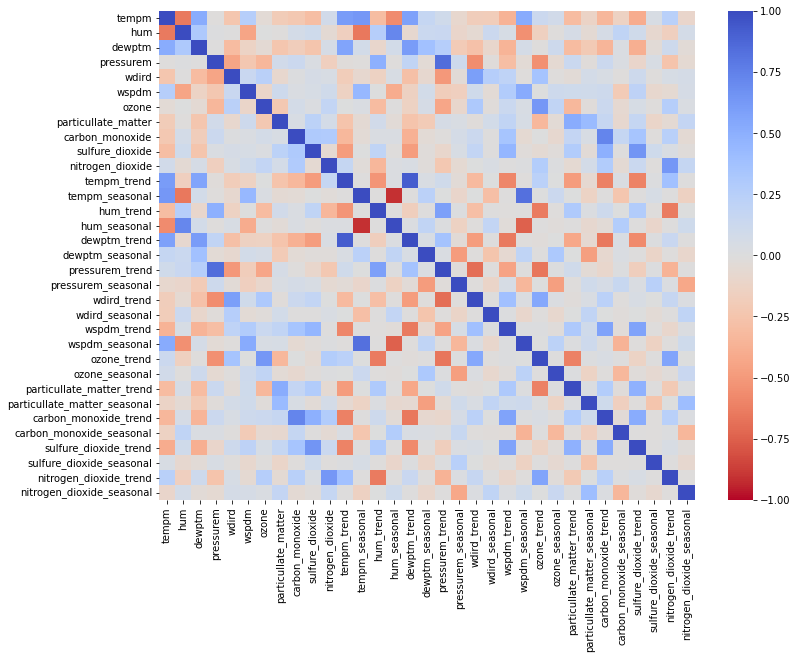

In [20]:

#correlation matrix

df_copy = df.copy()
df_copy = df_copy.drop(columns=['year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter','pressurem_log','pressurem_diff_1','pressurem_diff_2'])
corrmat = df_copy.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmin=-1, vmax=1, cmap='coolwarm_r',);

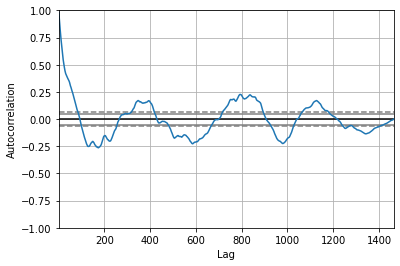

In [21]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['carbon_monoxide'])
plt.show()

# Predictive Analytics for Carbon Monoxide

In [22]:
mae = {}

## Statistical Models


### Exponential Smoothing

As we saw that the timeseries for carbon monoxide is a stationary time series, we choose to select S.E.S. model for a one-step-prediction

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


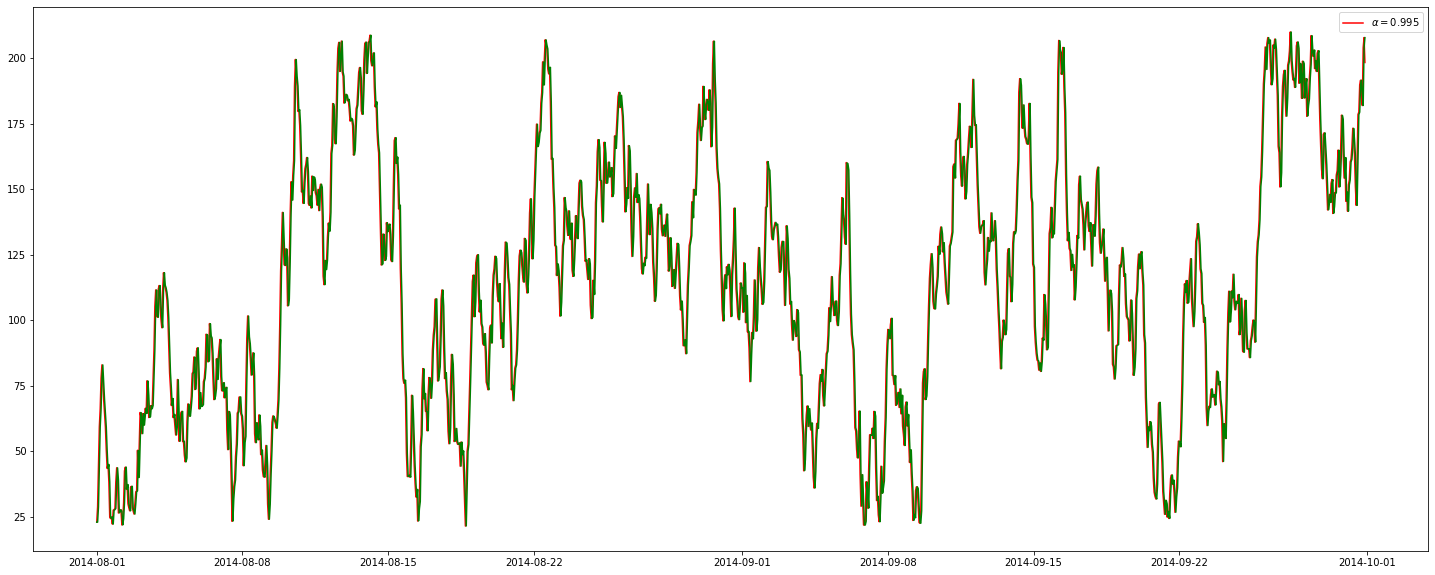

In [23]:
from statsmodels.tsa.api import  SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error


data = df.carbon_monoxide[:-1]
fit3 = SimpleExpSmoothing(data).fit()
fcast3 = fit3.forecast(1).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(25,10))
plt.plot(data, color="red")
plt.plot(fit3.fittedvalues, color="green")
plt.legend([fcast3.name])

ses_mae = mean_absolute_error([df.carbon_monoxide[-1]], [fcast3[0]])
mae['ses_mae']=ses_mae

In [24]:
print('MAE for the one-step ahead forecastin is ', ses_mae)

MAE for the one-step ahead forecastin is  4.297399335902838


### Multiple Linear Regression

In [25]:
from sklearn import linear_model

from pandas import concat
from pandas import DataFrame

# Humidity is excluded because its dependent variable from tempm
features = ['tempm','hum', 'dewptm', 'pressurem','wdird', 'wspdm','ozone','particullate_matter','sulfure_dioxide','nitrogen_dioxide','carbon_monoxide']
# reform series for our goal
def reform_series(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += ['{}(t-1)'.format(f) for f in features]  
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    names += ['{}(t)'.format(f) for f in features]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
  	agg.dropna(inplace=True)
  return agg


values = df[features].values
reframed = reform_series(values, 1, 1)
reframed.drop(reframed.columns[11:21], axis=1, inplace=True)

X = reframed[reframed.columns[:-1]].iloc[:-1]
y = reframed[reframed.columns[-1]].iloc[:-1]

regr = linear_model.LinearRegression()
regr.fit(X, y)

predictedCO = regr.predict([reframed[reframed.columns[:-1]].iloc[-1]])

multiple_regression_mae = mean_absolute_error([predictedCO],[reframed[reframed.columns[-1]].iloc[-1]])
mae['multiple_regression_mae']=multiple_regression_mae


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


In [26]:

print('MAE for the one-step ahead forecasting is ',multiple_regression_mae)

MAE for the one-step ahead forecasting is  3.4287456904325495


### Prophet

Prophet, or “Facebook Prophet,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook.

Prophet implements what they refer to as an additive time series forecasting model, and the implementation supports trends, seasonality, and holidays.

In [27]:
train_size = len(df)-1
test_size = 1

X = pd.DataFrame(df.carbon_monoxide)
X = X.reset_index(level=['datetime_pd'])
X['ds'] = X.datetime_pd
X['y'] = X.carbon_monoxide
X = X.drop(['carbon_monoxide','datetime_pd'],axis=1)

# x_valid = X.iloc[train_size:]
train = X.iloc[:train_size]

x_train, y_train = pd.DataFrame(X.iloc[:train_size, 0]), pd.DataFrame(X.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(X.iloc[train_size:, 0]), pd.DataFrame(X.iloc[train_size:, 1])

In [28]:
from fbprophet import Prophet

# Train the model
model = Prophet(yearly_seasonality=True)
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)
# # Calcuate metrics
prophet_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])

print('Mae: {}'.format(prophet_mae))
mae['prophet_mae']=prophet_mae


Mae: 26.11199604134643


### ARIMA

Steps to analyze ARIMA

Step 1 — Check stationarity: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

Step 2 — Difference: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.

Step 3 — Filter out a validation sample: This will be used to validate how accurate our model is. Use train test validation split to achieve this

Step 4 — Select AR and MA terms: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.

Step 5 — Build the model: Build the model and set the number of periods to forecast to N (depends on your needs).

Step 6 — Validate model: Compare the predicted values to the actuals in the validation sample.

In [29]:
from statsmodels.tsa.arima.model import ARIMA

# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.forecast(1)

# Calcuate metrics
arima_mae = mean_absolute_error(y_valid, y_pred)
mae['arima_mae']=arima_mae

print('MAE: {}'.format(arima_mae))

MAE: 1.5069800779417903


###  Vector Auto Regression

In [30]:
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR
features = ['tempm','hum', 'dewptm', 'pressurem','wdird', 'wspdm','ozone','particullate_matter','sulfure_dioxide','nitrogen_dioxide','carbon_monoxide']
train = df[features].iloc[:-1]

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
pred = model_fit.forecast(model_fit.y, steps=1)
pred = pred[0][-1]
y_valid = df['carbon_monoxide'].iloc[-1]
var_mae = mean_absolute_error([y_valid], [pred])
mae['var_mae']=var_mae

print('MAE: {}'.format(var_mae))


MAE: 3.4287456904327485


/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:34: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



## Machine Learning

### Random Forest

In [31]:
# finalize model and make a prediction for monthly births with random forest
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
 
features = ['tempm','hum', 'dewptm', 'pressurem','wdird', 'wspdm','ozone','particullate_matter','sulfure_dioxide','nitrogen_dioxide','carbon_monoxide']

# reform series for our goal
def reform_series(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += ['{}(t-{})'.format(f,i) for f in features]  
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    names += ['{}(t)'.format(f) for f in features]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
  	agg.dropna(inplace=True)
  return agg
 
# load the dataset
values = df[features].values
# transform the time series data into supervised learning
reformed = reform_series(values, n_in=6)
reformed.drop(reformed.columns[-11:-1], axis=1, inplace=True)
# split into input and output columns
trainX, trainy = reformed.iloc[:-1, :-1], reformed.iloc[:-1, -1]
testX, testy = reformed.iloc[-1, :-1], reformed.iloc[-1, -1]
# fit model
model = RandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new prediction


RandomForestRegressor(n_estimators=1000)

In [32]:

row = testX.values
# make a one-step prediction
yhat = model.predict(asarray([row]))
expected = testy
print('Predicted: %.3f, Expected: %.3f' % (yhat[0], expected))
random_forest_mae = mean_absolute_error([yhat[0]], [expected])
mae['random_forest_mae']=random_forest_mae

print('MAE: {}'.format(random_forest_mae))


Predicted: 200.477, Expected: 194.083
MAE: 6.393500000001268


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



### SVR

In [33]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(trainX, trainy)

SVR(C=1000.0, gamma=0.1)

In [35]:
row = reformed.iloc[-1, :-1].values
# make a one-step prediction
pred = svr_rbf.predict(asarray([row]))
expected = reformed.iloc[-1, -1]
print('Predicted: %.3f, Expected: %.3f' % (pred, expected))
svr_mae = mean_absolute_error(pred, [expected])
mae['svr_mae']=svr_mae

print('MAE: {}'.format(svr_mae))

Predicted: 113.866, Expected: 194.083
MAE: 80.21717102246659


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names



### Deep Learning

#### LSTM

In [36]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D,GlobalAveragePooling1D
import tensorflow as tf

In [37]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 


# normalize features
features = ['tempm', 'hum', 'dewptm', 'pressurem','wdird', 'wspdm','ozone','particullate_matter','sulfure_dioxide','nitrogen_dioxide','carbon_monoxide']
values = df[features].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reformed = reform_series(scaled,n_in=1)
# drop columns we don't want to predict
reformed.drop(reformed.columns[-11:-1], axis=1, inplace=True)

Epoch 1/50
15/15 - 3s - loss: 0.3400 - val_loss: 0.4208 - 3s/epoch - 180ms/step
Epoch 2/50
15/15 - 0s - loss: 0.2733 - val_loss: 0.3394 - 50ms/epoch - 3ms/step
Epoch 3/50
15/15 - 0s - loss: 0.2361 - val_loss: 0.2745 - 47ms/epoch - 3ms/step
Epoch 4/50
15/15 - 0s - loss: 0.2151 - val_loss: 0.2307 - 57ms/epoch - 4ms/step
Epoch 5/50
15/15 - 0s - loss: 0.2023 - val_loss: 0.2030 - 53ms/epoch - 4ms/step
Epoch 6/50
15/15 - 0s - loss: 0.1945 - val_loss: 0.1856 - 57ms/epoch - 4ms/step
Epoch 7/50
15/15 - 0s - loss: 0.1895 - val_loss: 0.1728 - 50ms/epoch - 3ms/step
Epoch 8/50
15/15 - 0s - loss: 0.1860 - val_loss: 0.1650 - 57ms/epoch - 4ms/step
Epoch 9/50
15/15 - 0s - loss: 0.1829 - val_loss: 0.1601 - 55ms/epoch - 4ms/step
Epoch 10/50
15/15 - 0s - loss: 0.1801 - val_loss: 0.1569 - 55ms/epoch - 4ms/step
Epoch 11/50
15/15 - 0s - loss: 0.1773 - val_loss: 0.1548 - 57ms/epoch - 4ms/step
Epoch 12/50
15/15 - 0s - loss: 0.1743 - val_loss: 0.1533 - 56ms/epoch - 4ms/step
Epoch 13/50
15/15 - 0s - loss: 0.1715

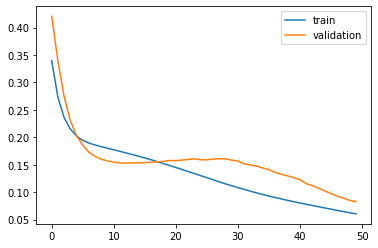

LSTM MAE: 1.942


In [38]:

## SPLIT DATA 
#split into train test
values = reformed.values
train_number = 1167
train = values[:train_number, :]
test = values[train_number:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:,:-1], test[:,-1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

## MODEL
from matplotlib import pyplot
# design network
model = Sequential()
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='rmsprop')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72,  validation_split=0.1, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()


## EVALUATION
from math import sqrt
from numpy import concatenate
# make a prediction
yhat = model.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
lstm_mae = mean_absolute_error(inv_y, inv_yhat)
mae['lstm_mae']=lstm_mae

print('LSTM MAE: %.3f' % lstm_mae )

#### MLP

In [39]:
from numpy import array

features = ['tempm', 'hum', 'dewptm', 'pressurem','wdird', 'wspdm','ozone','particullate_matter','sulfure_dioxide','nitrogen_dioxide','carbon_monoxide']
values = df[features].values
# frame as supervised learning
reformed = reform_series(values,n_in=1)
# drop columns we don't want to predict
reformed.drop(reformed.columns[-11:-1], axis=1, inplace=True)

train_number = 1167
train = values[:train_number, :]
test = values[train_number:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:,:-1], test[:,-1]




In [40]:

# define model
model = Sequential()
model.add(Dense(1000, activation='relu', input_dim=len(train_X[1])))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [41]:
# fit model
history = model.fit(train_X, train_y, epochs=100, validation_split=0.33, verbose=2)


Epoch 1/100
25/25 - 1s - loss: 3312.5679 - val_loss: 1589.1945 - 532ms/epoch - 21ms/step
Epoch 2/100
25/25 - 0s - loss: 1758.9536 - val_loss: 1968.0242 - 76ms/epoch - 3ms/step
Epoch 3/100
25/25 - 0s - loss: 1630.0546 - val_loss: 1773.9161 - 73ms/epoch - 3ms/step
Epoch 4/100
25/25 - 0s - loss: 1646.7238 - val_loss: 1510.6731 - 79ms/epoch - 3ms/step
Epoch 5/100
25/25 - 0s - loss: 1608.9620 - val_loss: 1959.4790 - 75ms/epoch - 3ms/step
Epoch 6/100
25/25 - 0s - loss: 1624.5261 - val_loss: 2005.3248 - 93ms/epoch - 4ms/step
Epoch 7/100
25/25 - 0s - loss: 1644.4631 - val_loss: 1549.3264 - 96ms/epoch - 4ms/step
Epoch 8/100
25/25 - 0s - loss: 1603.1462 - val_loss: 1983.6514 - 85ms/epoch - 3ms/step
Epoch 9/100
25/25 - 0s - loss: 1602.3633 - val_loss: 2498.3464 - 80ms/epoch - 3ms/step
Epoch 10/100
25/25 - 0s - loss: 1711.5103 - val_loss: 2579.8462 - 78ms/epoch - 3ms/step
Epoch 11/100
25/25 - 0s - loss: 1615.9475 - val_loss: 1426.7920 - 87ms/epoch - 3ms/step
Epoch 12/100
25/25 - 0s - loss: 1572.10

In [42]:
# make a prediction
yhat = model.predict(test_X)


# calculate RMSE
mlp_mae = sqrt(mean_absolute_error(test_y, yhat))
mae['mlp_mae']=mlp_mae

print('Test MAE: %.3f' % mlp_mae)

Test MAE: 7.490


## Evalution of Models

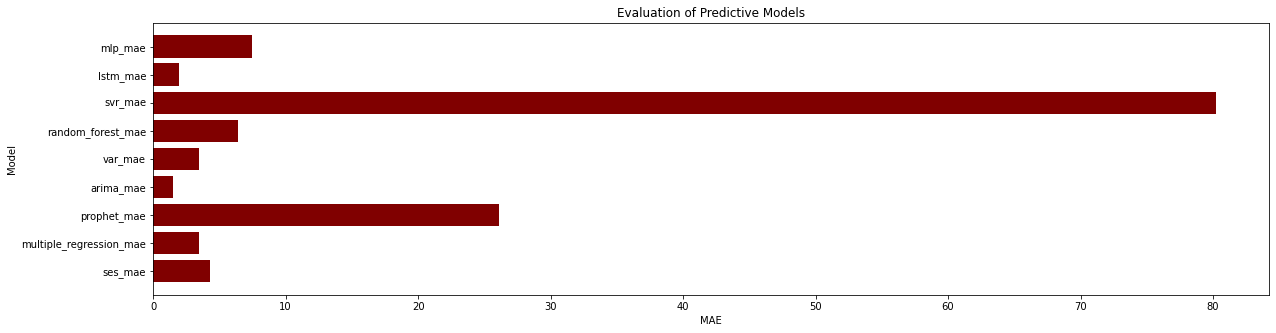

In [43]:

model = list(mae.keys())
mae_cum = list(mae.values())
  
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.barh(model, mae_cum, color ='maroon')

plt.xlabel("MAE")
plt.ylabel("Model")
plt.title("Evaluation of Predictive Models")
plt.show()